In [1]:
import os
# os.environ["CONDA_PREFIX"] = "/opt/conda"
%pip install -U -q uv

Note: you may need to restart the kernel to use updated packages.


In [2]:
!uv pip install small-text torchvision torchmetrics mlxtend torchsummary scikit-learn-intelex kaleido

Audited 7 packages in 84ms


# Imports


In [3]:
import random
import warnings
from pathlib import Path
from timeit import default_timer as timer

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from mlxtend.plotting import plot_confusion_matrix
from modAL.disagreement import vote_entropy_sampling
from modAL.models import ActiveLearner, Committee
from modAL.uncertainty import entropy_sampling, margin_sampling, uncertainty_sampling
from sklearnex import patch_sklearn
from skorch import NeuralNetClassifier
from torch import nn
from torcheval.metrics.functional import (
    multiclass_accuracy,
    multiclass_confusion_matrix,
    multiclass_f1_score,
    multiclass_precision,
    multiclass_recall,
)
from torchsummary import summary
from torchvision import datasets, models
from torchvision.transforms import ToTensor
from tqdm.auto import tqdm

if not os.path.exists("reports_FashionMNIST"):
    os.mkdir("reports_FashionMNIST")
patch_sklearn()
print("torch", torch.__version__)
print("torchvision", torchvision.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU List:", torch.cuda.device_count())
print("Current Device:", torch.cuda.current_device())
warnings.filterwarnings("ignore")

torch 2.1.0+cu121
torchvision 0.16.0+cu121
CUDA available: True
GPU List: 1
Current Device: 0


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Data

## FashionMNIST


In [4]:
FashionMNIST_train_data = datasets.FashionMNIST(
    root="data_FashionMNIST",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None,
)


FashionMNIST_test_data = datasets.FashionMNIST(
    root="data_FashionMNIST",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None,
)


x_train, y_train = FashionMNIST_train_data.data, np.array(
    FashionMNIST_train_data.targets
)


x_test, y_test = FashionMNIST_test_data.data, np.array(FashionMNIST_test_data.targets)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [6]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

(torch.Size([60000, 28, 28]), (60000,), torch.Size([10000, 28, 28]), (10000,))

In [7]:
FashionMNIST_class_names = FashionMNIST_train_data.classes
print(FashionMNIST_class_names)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [8]:
num_classes = len(FashionMNIST_class_names)
num_classes

10

In [9]:
class_to_idx_cif = FashionMNIST_train_data.class_to_idx
print(class_to_idx_cif)

{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


In [10]:
# # Show more images
# plt.figure(figsize=(9, 9))
# rows, cols = 4, 4

# for i in range(1, rows * cols + 1):
#     random_index = torch.randint(1, len(FashionMNIST_train_data), size=[1]).item()
#     plt.subplot(rows, cols, i)
#     image, label = FashionMNIST_train_data[random_index]
#     image = image.permute(1, 2, 0).numpy()
#     plt.imshow(image, cmap="gray")
#     plt.title(FashionMNIST_class_names[label])
#     plt.axis(False)

# plt.savefig("reports_FashionMNIST/FashionMNIST_imgs_labeled.png")
# plt.show()

## Unlabelling The Dataset


In [11]:
# Define the percentage of data without labels
percentage_without_labels = 0.8

# Calculate the number of samples without labels
num_samples_without_labels = int(
    len(FashionMNIST_train_data) * percentage_without_labels
)
num_samples_with_labels = len(FashionMNIST_train_data) - num_samples_without_labels

# Create indices for data with labels and without labels
indices_without_labels = np.random.choice(
    range(len(FashionMNIST_train_data)), size=num_samples_without_labels, replace=False
)
indices_with_labels = np.array(
    [i for i in range(len(FashionMNIST_train_data)) if i not in indices_without_labels]
)

x_initial = x_train[indices_with_labels]
y_initial = y_train[indices_with_labels]

x_pool = np.delete(x_train, indices_with_labels, axis=0)
y_pool = np.delete(y_train, indices_with_labels, axis=0)

x_pool = x_pool.unsqueeze(1).repeat(1, 3, 1, 1)
x_initial = x_initial.unsqueeze(1).repeat(1, 3, 1, 1)
x_test = x_test.unsqueeze(1).repeat(1, 3, 1, 1)

x_pool = x_pool.numpy()
x_initial = x_initial.numpy()
x_test = x_test.numpy()

x_pool = x_pool.astype(np.float32)
x_initial = x_initial.astype(np.float32)
x_test = x_test.astype(np.float32)

In [12]:
x_initial.shape, y_initial.shape, x_pool.shape, y_pool.shape, x_test.shape, y_test.shape

((12000, 3, 28, 28),
 (12000,),
 (48000, 3, 28, 28),
 (48000,),
 (10000, 3, 28, 28),
 (10000,))

In [13]:
len(FashionMNIST_train_data)

60000

In [14]:
FashionMNIST_train_data[1][1]

0

## Creating the DataLoaders


In [15]:
def numpy_to_dataloader(x, y, batch_size=32):
    dataset = torch.utils.data.TensorDataset(
        torch.tensor(x, dtype=torch.float32),
        torch.tensor(y),
    )
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [16]:
BATCH_SIZE_CIF = 32

FashionMNIST_train_data_loader = numpy_to_dataloader(
    x_initial, y_initial, BATCH_SIZE_CIF
)
FashionMNIST_test_data_loader = numpy_to_dataloader(x_test, y_test, BATCH_SIZE_CIF)

In [17]:
FashionMNIST_train_data_loader, FashionMNIST_test_data_loader

(<torch.utils.data.dataloader.DataLoader at 0x7f1d3aedbc90>,
 <torch.utils.data.dataloader.DataLoader at 0x7f1d32d93a50>)

In [18]:
print(
    f"Length of Training Data loader: {len(FashionMNIST_train_data_loader)}, Batches of {FashionMNIST_train_data_loader.batch_size}"
)
print(
    f"Length of Testing Data loader: {len(FashionMNIST_test_data_loader)}, Batches of {FashionMNIST_test_data_loader.batch_size}"
)

Length of Training Data loader: 375, Batches of 32
Length of Testing Data loader: 313, Batches of 32


# Raw Model

## Importing and Using ResNet 50 Architecture


In [19]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [20]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)
next(model.parameters()).device

device(type='cpu')

In [21]:
f = nn.Flatten(start_dim=0)  # The default start dim is 1
x = f(torch.randn(10, 7, 7))
x.size()

torch.Size([490])

In [22]:
rand_image_tensor = torch.randn(size=(32, 3, 28, 28))

In [23]:
rand_image_tensor.device

device(type='cpu')

In [24]:
model(rand_image_tensor)

tensor([[-1.4748e-01, -6.1805e-01, -1.5917e-02,  6.6468e-02, -9.7191e-02,
          4.1759e-01,  5.5312e-02, -2.4869e-01, -3.6530e-01, -2.9614e-01],
        [-1.8022e-01, -2.5538e-01,  1.4332e-01,  3.7277e-02, -2.2143e-01,
          1.7231e-01,  7.3148e-01, -2.3984e-01, -3.9259e-01, -4.8643e-01],
        [ 8.4767e-02,  1.8166e-01, -1.9575e-01, -3.7563e-01, -5.2913e-01,
          4.4532e-01,  1.6202e-01, -4.7618e-02, -6.1290e-01, -1.2349e+00],
        [ 6.8349e-02, -1.8666e-01,  9.7862e-02, -1.2580e-01, -7.0174e-02,
          2.1585e-01,  8.7879e-02, -2.1767e-03,  9.0284e-02, -6.1804e-01],
        [ 3.7145e-01, -3.0916e-01, -1.3382e-01, -3.9269e-01,  2.9736e-01,
          6.2219e-02,  1.7484e-01, -4.1494e-01, -3.1231e-01, -1.7617e-01],
        [ 3.1336e-01, -4.0618e-01, -1.6080e-01, -3.0886e-01, -3.3461e-02,
          6.8158e-02,  4.0632e-01, -1.6217e-01, -1.2125e-01, -6.5574e-01],
        [-8.8753e-02, -2.2589e-01,  9.2340e-02,  1.7772e-01,  6.9214e-02,
          6.0315e-01,  3.5886e-0

In [25]:
model.to(device)
next(model.parameters()).device

device(type='cuda', index=0)

## Printing the Architecture and Number of Training Parameters in each Layer


In [26]:
summary(model, (3, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           9,408
       BatchNorm2d-2           [-1, 64, 14, 14]             128
              ReLU-3           [-1, 64, 14, 14]               0
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]           4,096
       BatchNorm2d-6             [-1, 64, 7, 7]             128
              ReLU-7             [-1, 64, 7, 7]               0
            Conv2d-8             [-1, 64, 7, 7]          36,864
       BatchNorm2d-9             [-1, 64, 7, 7]             128
             ReLU-10             [-1, 64, 7, 7]               0
           Conv2d-11            [-1, 256, 7, 7]          16,384
      BatchNorm2d-12            [-1, 256, 7, 7]             512
           Conv2d-13            [-1, 256, 7, 7]          16,384
      BatchNorm2d-14            [-1, 25

In [27]:
# Picking a loss function and an optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

In [28]:
def display_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"Train time on device {device}: {total_time:.3f} seconds")

In [29]:
start = timer()
end = timer()
display_train_time(start, end, device="cpu")

Train time on device cpu: 0.000 seconds


In [30]:
def train_step(
    model: nn.Module,
    data_loader: torch.utils.data.dataloader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device = device,
):
    training_loss = []
    training_acc = []
    model.train()

    for batch, (x, y) in enumerate(data_loader):
        # Put the data on the target device
        x, y = x.to(device), y.to(device)
        # Forward Pass
        y_pred = model(x)
        # Loss
        loss = loss_fn(y_pred, y)
        training_loss.append(loss)
        training_acc.append(
            multiclass_accuracy(y_pred.argmax(dim=1), y, num_classes=10)
        )
        # Optimizer zero grad
        optimizer.zero_grad()
        # Loss Backward
        loss.backward()
        # optimizer step step step
        optimizer.step()
    # After looping over batches, divide the training loss over the number of batches to get the average loss per batch
    # train.data_loader (returns the number of batches)
    training_loss = torch.tensor(training_loss).mean()
    # Calculate the average training accuracy
    training_acc = torch.tensor(training_acc).mean()
    print(f"Training -> Loss: {training_loss:.3f} | Accuracy: {training_acc:.3f}")
    return training_acc, training_loss

In [31]:
def test_step(
    model: nn.Module,
    data_loader: torch.utils.data.dataloader,
    loss_fn: nn.Module,
    device: torch.device = device,
):
    testing_acc = []
    testing_loss = []
    testing_f1 = []
    testing_precision = []
    testing_recall = []
    model.eval()

    with torch.inference_mode():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            # Forward Pass
            y_test_pred = model(x)
            # Loss
            testing_loss.append(loss_fn(y_test_pred, y))
            # Accuracy
            testing_acc.append(
                multiclass_accuracy(y_test_pred.argmax(dim=1), y, num_classes=10)
            )
            # F1 Score
            testing_f1.append(
                multiclass_f1_score(y_test_pred.argmax(dim=1), y, num_classes=10)
            )
            # Precision
            testing_precision.append(
                multiclass_precision(y_test_pred.argmax(dim=1), y, num_classes=10)
            )
            # Recall
            testing_recall.append(
                multiclass_recall(y_test_pred.argmax(dim=1), y, num_classes=10)
            )
        testing_loss = torch.tensor(testing_loss).mean()
        testing_acc = torch.tensor(testing_acc).mean()
        testing_f1 = torch.tensor(testing_f1).mean()
        testing_precision = torch.tensor(testing_precision).mean()
        testing_recall = torch.tensor(testing_recall).mean()
    print(
        f"Testing -> Loss: {testing_loss:.3f} | Accuracy: {testing_acc:.3f} | F1 Score: {testing_f1:.3f} | Precision: {testing_precision:.3f} | Recall: {testing_recall:.3f}"
    )
    return testing_acc, testing_loss, testing_f1, testing_precision, testing_recall

## Training


In [32]:
# Set the seed and start the timer
torch.manual_seed(42)
torch.cuda.manual_seed(42)
train_start = timer()
# Set the number of epochs
epochs = 2
acc_TRAIN = []
acc_TEST = []
loss_TRAIN = []
loss_TEST = []
precision_result = []
recall_result = []
f1_result = []
# Training
for epoch in tqdm(range(epochs)):
    print(f"\nepoch: {epoch+1}\n--------------------------------------")
    ACC_TRAIN = 0
    LOSS_TRAIN = 0
    ACC_TEST = 0
    LOSS_TEST = 0
    F1 = 0
    PRECISION = 0
    RECALL = 0
    # Training
    ACC_TRAIN, LOSS_TRAIN = train_step(
        model, FashionMNIST_train_data_loader, loss_fn, optimizer, device
    )
    # Testing
    ACC_TEST, LOSS_TEST, F1, PRECISION, RECALL = test_step(
        model, FashionMNIST_test_data_loader, loss_fn, device
    )
    # List
    acc_TRAIN.append(ACC_TRAIN.detach().cpu().numpy())
    acc_TEST.append(ACC_TEST.detach().cpu().numpy())
    loss_TRAIN.append(LOSS_TRAIN.detach().cpu().numpy())
    loss_TEST.append(LOSS_TEST.detach().cpu().numpy())
    precision_result.append(PRECISION.detach().cpu().numpy())
    recall_result.append(RECALL.detach().cpu().numpy())
    f1_result.append(F1.detach().cpu().numpy())

# Compute the time of the training
print("\nTraining is finished!\n")
train_end = timer()
display_train_time(train_start, train_end, device=next(model.parameters()).device)

  0%|          | 0/2 [00:00<?, ?it/s]


epoch: 1
--------------------------------------
Training -> Loss: 1.512 | Accuracy: 0.577
Testing -> Loss: 0.612 | Accuracy: 0.781 | F1 Score: 0.781 | Precision: 0.781 | Recall: 0.781

epoch: 2
--------------------------------------
Training -> Loss: 0.830 | Accuracy: 0.716
Testing -> Loss: 0.648 | Accuracy: 0.749 | F1 Score: 0.749 | Precision: 0.749 | Recall: 0.749

Training is finished!

Train time on device cuda:0: 33.068 seconds


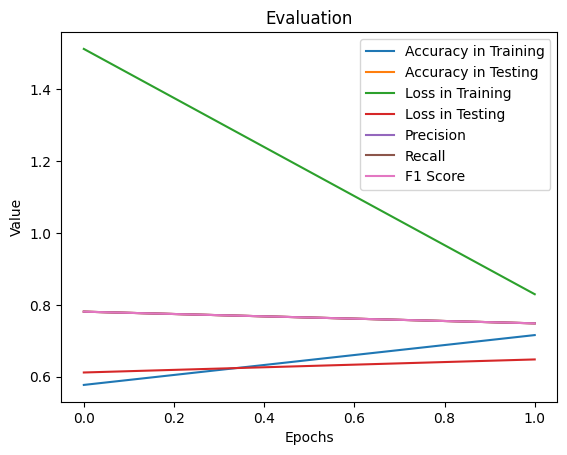

Precision: 0.7487020492553711
Recall: 0.7487020492553711
F1 Score: 0.7487020492553711


In [ ]:
fig, ax = plt.subplots()
# Plot the data
plt.plot(acc_TRAIN, label="Accuracy in Training")
plt.plot(acc_TEST, label="Accuracy in Testing")
plt.plot(loss_TRAIN, label="Loss in Training")
plt.plot(loss_TEST, label="Loss in Testing")
plt.plot(precision_result, label="Precision")
plt.plot(recall_result, label="Recall")
plt.plot(f1_result, label="F1 Score")

# Add labels and title
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Evaluation")
# Display the plot
plt.legend()
plt.savefig("reports_FashionMNIST/evals_base_model_before_al.png")
plt.show()
print(f"Accuracy in Training: {acc_TRAIN[-1]}")
print(f"Accuracy in Testing: {acc_TEST[-1]}")
print(f"Loss in Training: {loss_TRAIN[-1]}")
print(f"Loss in Testing: {loss_TEST[-1]}")
print(f"Precision: {precision_result[-1]}")
print(f"Recall: {recall_result[-1]}")
print(f"F1 Score: {f1_result[-1]}")

In [34]:
torch.manual_seed(42)

In [35]:
def eval_model(
    model: nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    device: torch.device = device,
):
    model.eval()
    loss = 0
    acc = 0
    f1 = 0
    precision = 0
    recall = 0
    y_pred_list = []
    with torch.inference_mode():
        for x, y in tqdm(data_loader):
            x, y = x.to(device), y.to(device)
            # Forward Pass
            y_pred = model(x)
            # Loss
            loss += loss_fn(y_pred, y)
            y_pred_list.append(y_pred.argmax(dim=1).cpu().numpy())
            acc += multiclass_accuracy(torch.argmax(y_pred, dim=1), y, num_classes=10)
            f1 += multiclass_f1_score(y_pred.argmax(dim=1), y, num_classes=10)
            precision += multiclass_precision(y_pred.argmax(dim=1), y, num_classes=10)
            recall += multiclass_recall(y_pred.argmax(dim=1), y, num_classes=10)
        loss /= len(data_loader)
        acc /= len(data_loader)
        f1 /= len(data_loader)
        precision /= len(data_loader)
        recall /= len(data_loader)
        y_pred_list = np.concatenate(y_pred_list)
    return {
        "Model Name": model.__class__.__name__,
        "Model Loss": loss.item(),
        "Model Accuracy": acc,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall,
    }, y_pred_list

In [36]:
# Testing the model
model_results, y_pred = eval_model(model, FashionMNIST_test_data_loader, loss_fn)

  0%|          | 0/313 [00:00<?, ?it/s]

In [37]:
model_results

{'Model Name': 'ResNet',
 'Model Loss': 0.6484854817390442,
 'Model Accuracy': tensor(0.7486, device='cuda:0'),
 'F1 Score': tensor(0.7486, device='cuda:0'),
 'Precision': tensor(0.7486, device='cuda:0'),
 'Recall': tensor(0.7486, device='cuda:0')}

In [38]:
y_pred.shape

(10000,)

## Evaluating Model Visually


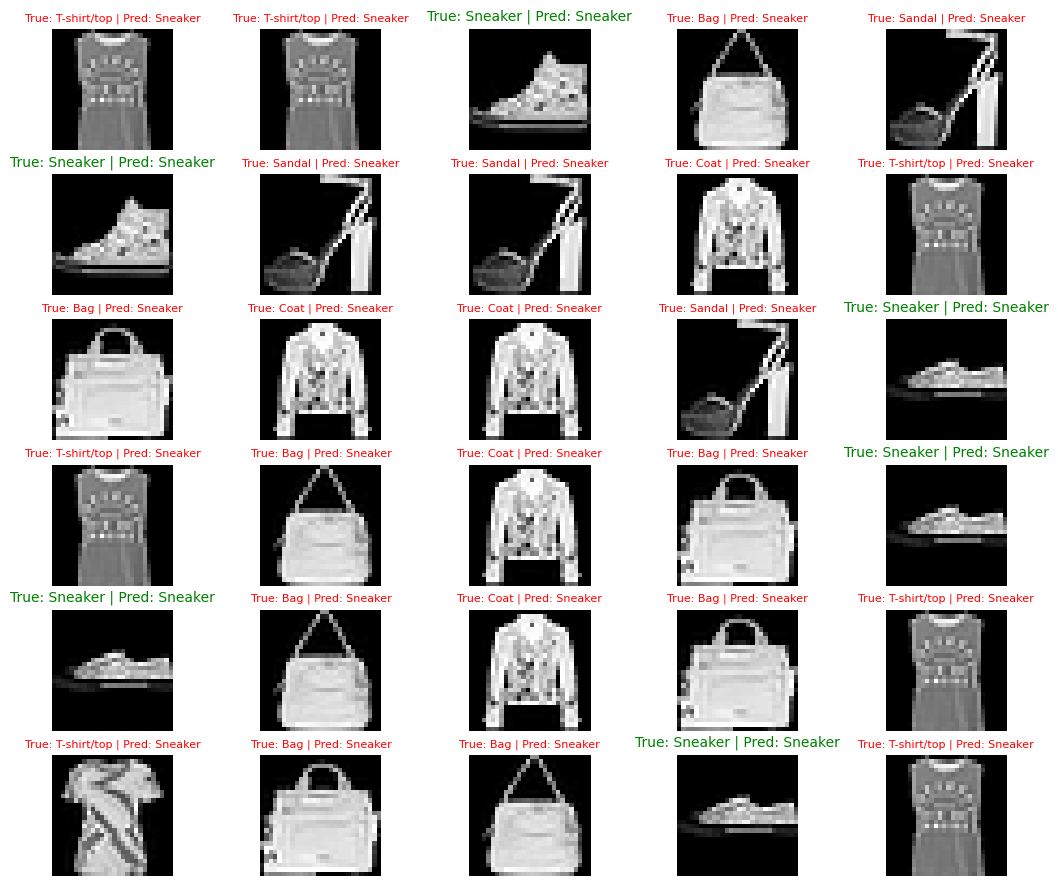

In [39]:
test_samples = []
test_labels = []

for sample, label in random.sample(list(FashionMNIST_test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

rows = 6
cols = 5

plt.figure(figsize=(13, 11))

model.eval()
with torch.inference_mode():
    for i in range(1, rows * cols + 1):
        plt.subplot(rows, cols, i)
        random_index = torch.randint(1, 9, size=[1]).item()
        image, label = test_samples[random_index], test_labels[random_index]
        pred_label = model(image.unsqueeze(0).repeat(1, 3, 1, 1).to(device)).argmax()
        image = image.permute(1, 2, 0).numpy()
        plt.imshow(image, cmap="gray")
        if pred_label == label:
            plt.title(
                f"True: {FashionMNIST_class_names[label]} | Pred: {FashionMNIST_class_names[pred_label]}",
                c="g",
                fontsize=10,
            )
        else:
            plt.title(
                f"True: {FashionMNIST_class_names[label]} | Pred: {FashionMNIST_class_names[pred_label]}",
                c="r",
                fontsize=8,
            )
        plt.axis(False)
plt.savefig("reports_FashionMNIST/preds_base_model_before_al.png")

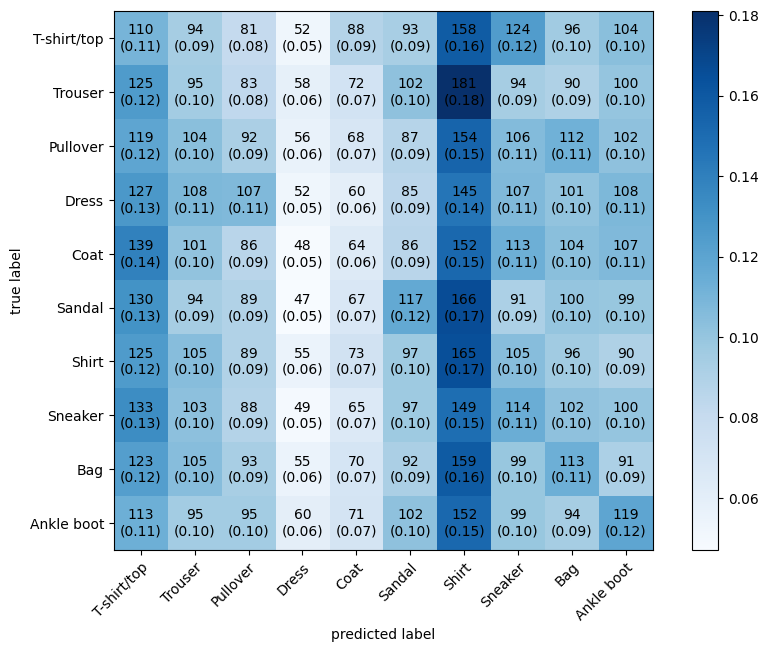

In [40]:
confusion_matrix = multiclass_confusion_matrix(
    torch.tensor(y_pred), torch.tensor(FashionMNIST_test_data.targets), num_classes=10
)
plot_confusion_matrix(
    conf_mat=confusion_matrix.numpy(),
    class_names=FashionMNIST_class_names,
    figsize=(10, 7),
    show_absolute=True,
    show_normed=True,
    colorbar=True,
)
plt.savefig("reports_FashionMNIST/conf_mat_raw_model_before_al.png")

## Saving the Model


In [41]:
# Create the models path
MODELS_PATH = Path("models")
MODELS_PATH.mkdir(parents=True, exist_ok=True)
# Create model save
MODEL_NAME = "base_model.pth"
MODEL_SAVE_PATH = MODELS_PATH / MODEL_NAME
# Save the model
print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

Saving model to models/base_model.pth


## Load the Model


In [42]:
# Create a model instance
trained_model = models.resnet50().to(device)
trained_model.fc = nn.Linear(model.fc.in_features, 10)
trained_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
trained_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [43]:
summary(trained_model, (3, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           9,408
       BatchNorm2d-2           [-1, 64, 14, 14]             128
              ReLU-3           [-1, 64, 14, 14]               0
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]           4,096
       BatchNorm2d-6             [-1, 64, 7, 7]             128
              ReLU-7             [-1, 64, 7, 7]               0
            Conv2d-8             [-1, 64, 7, 7]          36,864
       BatchNorm2d-9             [-1, 64, 7, 7]             128
             ReLU-10             [-1, 64, 7, 7]               0
           Conv2d-11            [-1, 256, 7, 7]          16,384
      BatchNorm2d-12            [-1, 256, 7, 7]             512
           Conv2d-13            [-1, 256, 7, 7]          16,384
      BatchNorm2d-14            [-1, 25

# Active Learning


In [44]:
trained_model = NeuralNetClassifier(
    trained_model,
    criterion=nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    train_split=None,
    verbose=0,
    device=device,
)

In [52]:
def active_learning(pool_x, pool_y, method, model_estimator, num_classes, class_names):
    learner = None
    cycles = 10
    acc_train = []
    acc_test = []
    precision_result = []
    recall_result = []
    f1_result = []
    if method == "uncertainty_sampling":
        print('Training on the initial data')
        learner = ActiveLearner(
            estimator=model_estimator,
            X_training=x_initial,
            y_training=y_initial,
            query_strategy=uncertainty_sampling,
        )
    elif method == "margin_sampling":
        print("Training on the initial data")
        learner = ActiveLearner(
            estimator=model_estimator,
            X_training=x_initial,
            y_training=y_initial,
            query_strategy=margin_sampling,
        )
    elif method == "entropy_sampling":
        print("Training on the initial data")
        learner = ActiveLearner(
            estimator=model_estimator,
            X_training=x_initial,
            y_training=y_initial,
            query_strategy=entropy_sampling,
        )
    elif method == "random_sampling":
        def random_sampling(Learner, pool_x, n_instances):
            n_samples = len(pool_x)
            query_idx = np.random.choice(
                range(n_samples), size=n_instances, replace=False
            )
            X_query = pool_x[query_idx]
            return query_idx, X_query
        
        print("Training on the initial data")
        learner = ActiveLearner(
            estimator=model_estimator,
            X_training=x_initial,
            y_training=y_initial,
            query_strategy=random_sampling,
        )
    else:
        print("Invalid Input")
    print(f"Starting Active Learning with {method.replace('_', ' ')} method")
    for cycle in range(cycles):
        print(f"Cycle: {cycle+1}")
        query_idx, _ = learner.query(pool_x, n_instances=100)
        learner.teach(X=pool_x[query_idx], y=pool_y[query_idx])
        pool_x = np.delete(pool_x, query_idx, axis=0)
        pool_y = np.delete(pool_y, query_idx, axis=0)
        model_accuracy = learner.score(
            np.concatenate((x_initial, pool_x), axis=0),
            np.concatenate((y_initial, pool_y), axis=0),
        )
        acc_train.append(model_accuracy)
        y_pred = learner.predict(x_test)
        # Compute the metrics
        acc_test.append(
            multiclass_accuracy(
                torch.tensor(y_pred), torch.tensor(y_test), num_classes=num_classes
            )
        )
        precision_result.append(
            multiclass_precision(
                torch.tensor(y_pred), torch.tensor(y_test), num_classes=num_classes
            )
        )
        recall_result.append(
            multiclass_recall(
                torch.tensor(y_pred), torch.tensor(y_test), num_classes=num_classes
            )
        )
        f1_result.append(
            multiclass_f1_score(
                torch.tensor(y_pred), torch.tensor(y_test), num_classes=num_classes
            )
        )
        print(f"\tTraining Accuracy: {acc_train[-1]:.3f}")
        print(f"\tTesting Accuracy: {acc_test[-1]:.3f}")
        print(f"\tPrecision: {precision_result[-1]:.3f}")
        print(f"\tRecall: {recall_result[-1]:.3f}")
        print(f"\tF1 Score: {f1_result[-1]:.3f}")
    print(f"Active Learning with {method} method is finished")
    confusion_matrix = multiclass_confusion_matrix(
        torch.tensor(y_pred), torch.tensor(y_test), num_classes=10
    )
    plot_confusion_matrix(
        conf_mat=confusion_matrix.numpy(),
        class_names=class_names,
        figsize=(10, 7),
        show_absolute=True,
        show_normed=True,
        colorbar=True,
    )
    plt.savefig(f"reports_FashionMNIST/confusion_matrix_{method}_after_al.png")
    return {
        "Train Accuracy": acc_train,
        "Test Accuracy": acc_test,
        "Precision": precision_result,
        "Recall": recall_result,
        "F1 Score": f1_result,
    }

## Random Sampling

In [46]:
# (
#     acc_random_sampling,
#     precision_result_random_sampling,
#     recall_result_random_sampling,
#     f1_result_random_sampling,
# ) = active_learning(
#     x_pool,
#     y_pool,
#     x_initial,
#     y_initial,
#     x_test,
#     y_test,
#     "random_sampling",
#     trained_model,
#     10,
#     FashionMNIST_class_names,
# )

## Uncertainty Sampling

Training on the initial data
Starting Active Learning with uncertainty sampling method
Cycle: 1
	Training Accuracy: 0.907
	Testing Accuracy: 0.881
	Precision: 0.881
	Recall: 0.881
	F1 Score: 0.881
Cycle: 2
	Training Accuracy: 0.915
	Testing Accuracy: 0.888
	Precision: 0.888
	Recall: 0.888
	F1 Score: 0.888
Cycle: 3
	Training Accuracy: 0.915
	Testing Accuracy: 0.887
	Precision: 0.887
	Recall: 0.887
	F1 Score: 0.887
Cycle: 4
	Training Accuracy: 0.913
	Testing Accuracy: 0.882
	Precision: 0.882
	Recall: 0.882
	F1 Score: 0.882
Cycle: 5
	Training Accuracy: 0.919
	Testing Accuracy: 0.889
	Precision: 0.889
	Recall: 0.889
	F1 Score: 0.889
Cycle: 6
	Training Accuracy: 0.907
	Testing Accuracy: 0.876
	Precision: 0.876
	Recall: 0.876
	F1 Score: 0.876
Cycle: 7
	Training Accuracy: 0.919
	Testing Accuracy: 0.887
	Precision: 0.887
	Recall: 0.887
	F1 Score: 0.887
Cycle: 8
	Training Accuracy: 0.922
	Testing Accuracy: 0.888
	Precision: 0.888
	Recall: 0.888
	F1 Score: 0.888
Cycle: 9
	Training Accuracy: 0.92

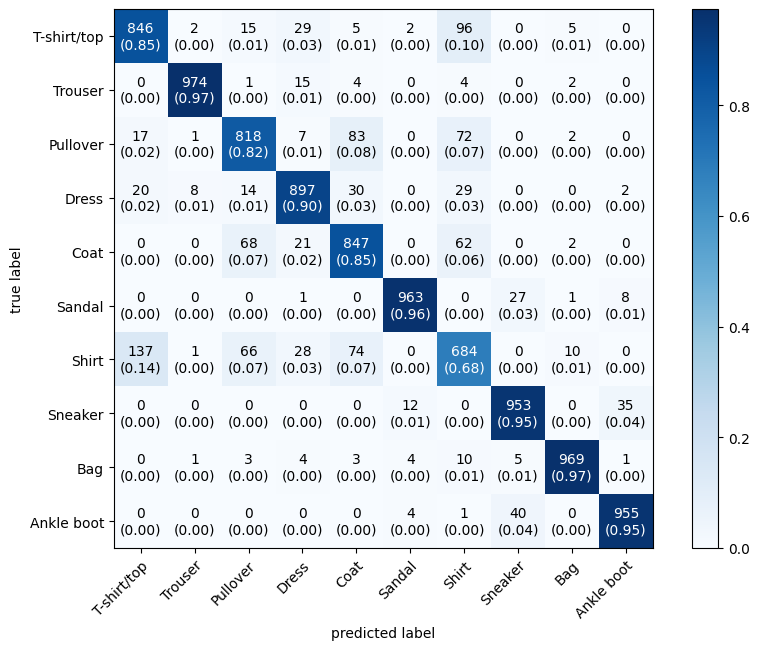

In [53]:
results_uncertainty_sampling = active_learning(
    x_pool, y_pool, "uncertainty_sampling", trained_model, 10, FashionMNIST_class_names
)

## Margin Sampling

In [48]:
# (
#     acc_margin_sampling,
#     precision_result_margin_sampling,
#     recall_result_margin_sampling,
#     f1_result_margin_sampling,
# ) = active_learning(
#     x_pool,
#     y_pool,
#     x_initial,
#     y_initial,
#     x_test,
#     y_test,
#     "margin_sampling",
#     trained_model,
#     10,
#     FashionMNIST_class_names,
# )

## Entropy Sampling

In [49]:
# (
#     acc_entropy_sampling,
#     precision_result_entropy_sampling,
#     recall_result_entropy_sampling,
#     f1_result_entropy_sampling,
# ) = active_learning(
#     x_pool,
#     y_pool,
#     x_initial,
#     y_initial,
#     x_test,
#     y_test,
#     "entropy_sampling",
#     trained_model,
#     10,
#     FashionMNIST_class_names,
# )

# Plot All Metrics


## Accuracy


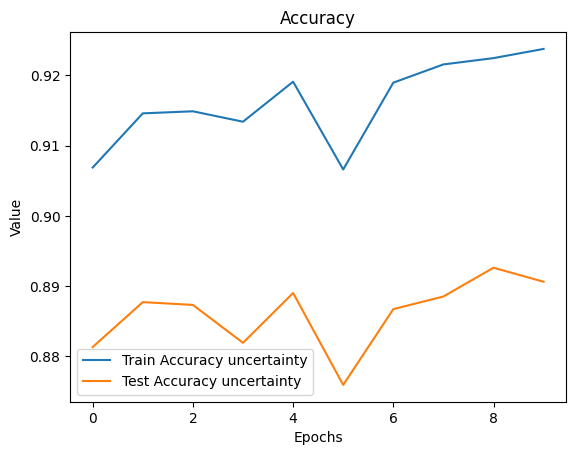

Train Accuracy uncertainty: 0.9237796610169492
Test Accuracy uncertainty: 0.8906000256538391


In [54]:
# Create a figure and axes
fig, ax = plt.subplots()
# Plot the data
# plt.plot(acc_random_sampling, label="acc_random_sampling")
plt.plot(
    results_uncertainty_sampling["Train Accuracy"], label="Train Accuracy uncertainty"
)
plt.plot(
    results_uncertainty_sampling["Test Accuracy"], label="Test Accuracy uncertainty"
)
# plt.plot(acc_margin_sampling, label="acc_margin_sampling")
# plt.plot(acc_entropy_sampling, label="acc_entropy_sampling")

# Add labels and title
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Accuracy")
# Display the plot
plt.legend()
plt.savefig("reports_FashionMNIST/acc_base_model_after_al.png")
plt.show()

# print(f"acc_random_sampling: {acc_random_sampling[-1]}")
print(f"Train Accuracy uncertainty: {results_uncertainty_sampling['Train Accuracy'][-1]}")
print(f"Test Accuracy uncertainty: {results_uncertainty_sampling['Test Accuracy'][-1]}")
# print(f"acc_margin_sampling: {acc_margin_sampling[-1]}")
# print(f"acc_entropy_sampling: {acc_entropy_sampling[-1]}")

## Precision


NameError: name 'precision_result_random_sampling' is not defined

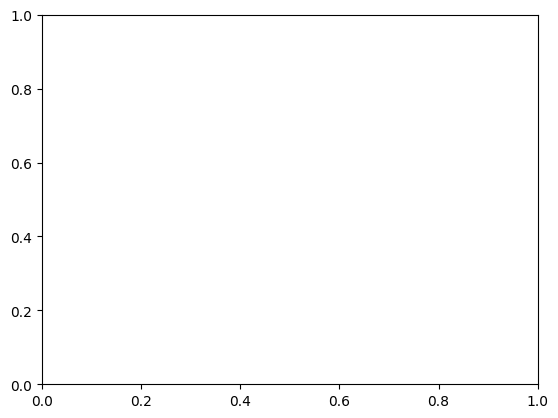

In [51]:
# Create a figure and axes
fig, ax = plt.subplots()
# Plot the data
plt.plot(precision_result_random_sampling, label="precision_result_random_sampling")
plt.plot(
    precision_result_uncertainty_sampling, label="precision_result_uncertainty_sampling"
)
plt.plot(precision_result_margin_sampling, label="precision_result_margin_sampling")
plt.plot(precision_result_entropy_sampling, label="precision_result_entropy_sampling")

# Add labels and title
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Precision")
# Display the plot
plt.legend()
plt.savefig("reports_FashionMNIST/prec_base_model_after_al.png")
plt.show()

print(f"precision_result_random_sampling: {precision_result_random_sampling[-1]}")
print(
    f"precision_result_uncertainty_sampling: {precision_result_uncertainty_sampling[-1]}"
)
print(f"precision_result_margin_sampling: {precision_result_margin_sampling[-1]}")
print(f"precision_result_entropy_sampling: {precision_result_entropy_sampling[-1]}")

## Recall


In [ ]:
# Create a figure and axes
fig, ax = plt.subplots()
# Plot the data
plt.plot(recall_result_random_sampling, label="recall_result_random_sampling")
plt.plot(recall_result_uncertainty_sampling, label="recall_result_uncertainty_sampling")
plt.plot(recall_result_margin_sampling, label="recall_result_margin_sampling")
plt.plot(recall_result_entropy_sampling, label="recall_result_entropy_sampling")

# Add labels and title
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Recall")
# Display the plot
plt.legend()
plt.savefig("reports_FashionMNIST/recall_base_model_after_al.png")
plt.show()

print(f"recall_result_random_sampling: {recall_result_random_sampling[-1]}")
print(f"recall_result_uncertainty_sampling: {recall_result_uncertainty_sampling[-1]}")
print(f"recall_result_margin_sampling: {recall_result_margin_sampling[-1]}")
print(f"recall_result_entropy_sampling: {recall_result_entropy_sampling[-1]}")

## F1 Score


In [ ]:
# Create a figure and axes
fig, ax = plt.subplots()
# Plot the data
plt.plot(f1_result_random_sampling, label="f1_result_random_sampling")
plt.plot(f1_result_uncertainty_sampling, label="f1_result_uncertainty_sampling")
plt.plot(f1_result_margin_sampling, label="f1_result_margin_sampling")
plt.plot(f1_result_entropy_sampling, label="f1_result_entropy_sampling")

# Add labels and title
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("F1 Score")
# Display the plot
plt.legend()
plt.savefig("reports_FashionMNIST/f1_base_model_after_al.png")
plt.show()

print(f"f1_result_random_sampling: {f1_result_random_sampling[-1]}")
print(f"f1_result_uncertainty_sampling: {f1_result_uncertainty_sampling[-1]}")
print(f"f1_result_margin_sampling: {f1_result_margin_sampling[-1]}")
print(f"f1_result_entropy_sampling: {f1_result_entropy_sampling[-1]}")